# Ablation Experiments (Fixed-Teacher- and Contracting Linear Dynamical Systems)

### Setup:

**Imports, Paths, GPU-Settings and Flags:**

In [ ]:
import os
import jax
import pickle as pkl
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state
from typing import Dict, List
from matplotlib import cm, colors
from matplotlib.colors import TwoSlopeNorm


import src.models.auxiliary_models as aux
from src.training_init import TrainingInitializer
from src.train import _compute_loss
from src.util.probings.probe_layers import ProbeLayers
from src.models.auxiliary_models import learn_parameters_chebyshev
from src.models.auxiliary_models import GDSequenceSolver, LeastSquaresSequenceSolver
from src.util.sequence_performance.sequenceloss_eval import SequencePredictionEvaluator
from configs.config import get_experiment_config, get_model_config

In [37]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.devices()

models_constr = {'full_mesa': 'fully_obs_constructed_mesa.1.4.40.50.20.False.False.False.False.0.True.True.4.False.False.False.False'}
models_constr_lay = lambda lay: f'fully_obs_constructed_transformer.{lay}.{2 if lay == 1 else 4}.40.50.20.False.False.False.False.0.True.True.4.False.False.False.False'

rerun_models = False
rerun_analyses = False
store_results = False

path_chebyshev_contracting = 'experiment_results/linear_seq_fully/contracting/cheb_params_contracting.pkl'
path_chebyshev_fixedw = 'experiment_results/linear_seq_fully/fixedw/cheb_params_fixedw.pkl'

path_model_contracting_1 = 'experiment_results/linear_seq_fully/contracting/contracting_tf_1l_constr.pkl'
path_model_contracting_2 = 'experiment_results/linear_seq_fully/contracting/contracting_tf_2l_constr.pkl'
path_model_contracting_4 = 'experiment_results/linear_seq_fully/contracting/contracting_tf_4l_constr.pkl'
path_model_contracting_6 = 'experiment_results/linear_seq_fully/contracting/contracting_tf_6l_constr.pkl'
path_model_contracting_mesa = 'experiment_results/linear_seq_fully/contracting/contracting_mesa_constr.pkl'

path_seqperf_contracting_single = 'experiment_results/linear_seq_fully/contracting/seqperf_results_contracting_single.pkl'
path_seqperf_contracting_multi = 'experiment_results/linear_seq_fully/contracting/seqperf_results_contracting_multi.pkl'
path_probing_contracting_multi = 'experiment_results/linear_seq_fully/contracting/probing_results_contracting_multi.pkl'

path_model_fixedw_1 = 'experiment_results/linear_seq_fully/fixedw/fixedw_tf_1l_constr.pkl'
path_model_fixedw_2 = 'experiment_results/linear_seq_fully/fixedw/fixedw_tf_2l_constr.pkl'
path_model_fixedw_4 = 'experiment_results/linear_seq_fully/fixedw/fixedw_tf_4l_constr.pkl'
path_model_fixedw_6 = 'experiment_results/linear_seq_fully/fixedw/fixedw_tf_6l_constr.pkl'
path_model_fixedw_mesa = 'experiment_results/linear_seq_fully/fixedw/fixedw_mesa_constr.pkl'

path_seqperf_fixedw_single = 'experiment_results/linear_seq_fully/fixedw//seqperf_results_fixedw_single.pkl'
path_seqperf_fixedw_multi = 'experiment_results/linear_seq_fully/fixedw/seqperf_results_fixedw_multi.pkl'
path_probing_fixedw_multi = 'experiment_results/linear_seq_fully/fixedw/probing_results_fixedw_multi.pkl'

print(f'Running on Devices: {devices},\nRe-Run Analysis: {rerun_analyses}, \nRe-Run Models: {rerun_models}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: False, 
Re-Run Models: False, 
Store Results: False


## Contracting linear dynamical systems:

### Single-layer:

In [5]:
exp_config_contracting = get_experiment_config(experiment='contracting', seeds=[1, 11, 111, 1111, 11111])
(model_tf_contracting_1, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr_lay(1)), 
                                                                                        experiment_config=exp_config_contracting).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_contracting_1, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
        state_tf_contracting_1, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_tf_contracting_1,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_contracting_1}')
        a = {'params' : state_tf_contracting_1.params}
        with open(path_model_contracting_1, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_contracting_1, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_contracting_1 = train_state.TrainState.create(apply_fn=model_tf_contracting_1.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_transformer  layers: 1  heads:  2  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [6]:
exp_config_contracting.optim.peak_lr = 4e-4
(model_mesa_contracting, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr['full_mesa']), 
                                                                                        experiment_config=exp_config_contracting).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_mesa_contracting, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
        state_mesa_contracting, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_mesa_contracting,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_contracting_mesa}')
        a = {'params' : state_mesa_contracting.params}
        with open(path_model_contracting_mesa, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_contracting_mesa, 'rb') as handle:
        a = pkl.load(handle)
    state_mesa_contracting = train_state.TrainState.create(apply_fn=model_mesa_contracting.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_mesa  layers: 1  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [7]:
loss_fn = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))
gd_solver = GDSequenceSolver(eta=0.000883434,
                             lamb=0.0)
if rerun_models:
    gd_solver.opt_eta(minv=0.00001,
                    maxv=0.001,
                    steps=25,
                    data_generator=data_generator,
                    loss_fn=_compute_loss,
                    constr=True)
model_names = ['transformer', 'gd']

seq_evaluator = SequencePredictionEvaluator(data_generator=data_generator,
                                            test_batch_size=256,
                                            seeds=exp_config_contracting.seeds,
                                            model_list = model_names,
                                            models = [model_tf_contracting_1, gd_solver],
                                            states = [state_tf_contracting_1, None],
                                            loss_fn = loss_fn)

if rerun_models:
    seq_loss_dict_one_contracting = seq_evaluator.run()
    if store_results:
        print(f'Storing performance evaluation dict. in path=\'{path_seqperf_contracting_single}\'')
        with open(path_seqperf_contracting_single, 'wb') as handle:
            pkl.dump(seq_loss_dict_one_contracting, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_seqperf_contracting_single, 'rb') as handle:
        seq_loss_dict_one_contracting = pkl.load(handle)

### Multi-layer:

In [8]:
exp_config_contracting = get_experiment_config(experiment='contracting', seeds=[1, 11, 111, 1111, 11111])
(model_tf_contracting_2, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr_lay(2)), 
                                                                                        experiment_config=exp_config_contracting).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_contracting_2, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
        state_tf_contracting_2, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_tf_contracting_2,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_contracting_2}')
        a = {'params' : state_tf_contracting_2.params}
        with open(path_model_contracting_2, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_contracting_2, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_contracting_2 = train_state.TrainState.create(apply_fn=model_tf_contracting_2.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_transformer  layers: 2  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [10]:
exp_config_contracting = get_experiment_config(experiment='contracting', seeds=[1, 11, 111, 1111, 11111])
(model_tf_contracting_4, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr_lay(4)), 
                                                                                        experiment_config=exp_config_contracting).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_contracting_4, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(100):
        state_tf_contracting_4, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_tf_contracting_4,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_contracting_4}')
        a = {'params' : state_tf_contracting_4.params}
        with open(path_model_contracting_4, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_contracting_4, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_contracting_4 = train_state.TrainState.create(apply_fn=model_tf_contracting_4.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_transformer  layers: 4  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [11]:
exp_config_contracting = get_experiment_config(experiment='contracting', seeds=[1, 11, 111, 1111, 11111])
(model_tf_contracting_6, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr_lay(6)), 
                                                                                        experiment_config=exp_config_contracting).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_contracting_6, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
        state_tf_contracting_6, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_tf_contracting_6,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_contracting_6}')
        a = {'params' : state_tf_contracting_6.params}
        with open(path_model_contracting_6, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_contracting_6, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_contracting_6 = train_state.TrainState.create(apply_fn=model_tf_contracting_6.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_transformer  layers: 6  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [21]:
if rerun_models:
    alphas_contracting, betas_contracting = learn_parameters_chebyshev(num_steps=6, 
                                                                        train_len=20000, 
                                                                        experiment_config=exp_config_contracting, 
                                                                        data_generator=data_generator.data_generator)    # We use the "underlying" data-generator from the constructed-data generator
    if store_results:
        print(f'Storing params at {path_chebyshev_contracting}')
        with open(path_chebyshev_contracting, 'wb') as handle:
            pkl.dump({'alphas': alphas_contracting, 'betas': betas_contracting}, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_chebyshev_contracting, 'rb') as handle:
        a = pkl.load(handle)
    alphas_contracting = a['alphas']
    betas_contracting = a['betas']

lsq_solver = LeastSquaresSequenceSolver(approximator='chebyshev',
                                        seq_len=50,
                                        alphas=alphas_contracting,
                                        betas=betas_contracting)

if rerun_models:
    opt_l = lsq_solver.opt_lamb(minv=0.001, 
                                maxv=3, 
                                steps=25, 
                                data_generator=data_generator,
                                loss_fn=_compute_loss,
                                part_obs_constr=False,
                                constr=True)

In [22]:
model_names = ['transformer','transformer','transformer','transformer','mesa-transformer','lsq']
loss_fn = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))
seq_evaluator = SequencePredictionEvaluator(data_generator=data_generator,
                                            test_batch_size=256,
                                            seeds=exp_config_contracting.seeds,
                                            model_list = model_names,
                                            models = [model_tf_contracting_1, model_tf_contracting_2, model_tf_contracting_4, model_tf_contracting_6, model_mesa_contracting, lsq_solver],
                                            states = [state_tf_contracting_1, state_tf_contracting_2, state_tf_contracting_4, state_tf_contracting_6, state_mesa_contracting, None],
                                            loss_fn = loss_fn)

if rerun_models:
    seq_loss_dict_multi_contracting = seq_evaluator.run()
    if store_results:
        print(f'Storing performance evaluation dict. in path=\'{path_seqperf_contracting_multi}\'')
        with open(path_seqperf_contracting_multi, 'wb') as handle:
            pkl.dump(seq_loss_dict_multi_contracting, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_seqperf_contracting_multi, 'rb') as handle:
        seq_loss_dict_multi_contracting = pkl.load(handle)

In [25]:
layer_prober = ProbeLayers(experiment_config=exp_config_contracting,
                           data_generator=data_generator,
                           model_tf=model_tf_contracting_6,
                           state_tf=state_tf_contracting_6,
                           probes_list=['curr_probe', 'next_probe', 'inverse_curr_probe'],
                           inv_fn=aux.batched_chebyshev(6, alphas_contracting, betas_contracting),
                           probe_lambda=1.33339,    # line-searched
                           clean_target_probe=True,
                           target_probe_threshold=2)
if rerun_models:
    result_dict = layer_prober.run()
    if store_results:
        print(f'Storing probing dict. in path=\'{path_probing_contracting_multi}\'')
        with open(path_probing_contracting_multi, 'wb') as handle:
            pkl.dump(result_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_probing_contracting_multi, 'rb') as handle:
        result_dict = pkl.load(handle)

### Visualize Results:

**Results:**

2
plot
plot
6
plot
plot
plot
plot
plot
plot


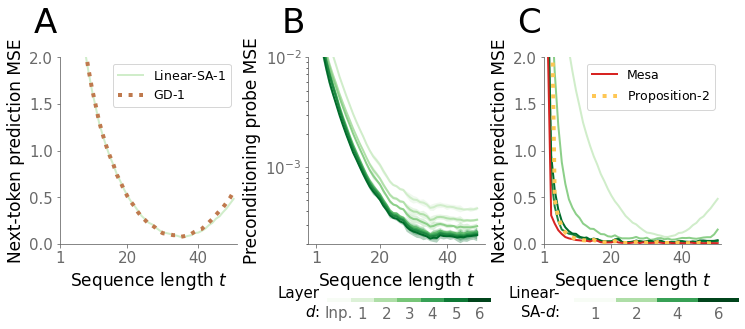

In [30]:
legend_fontsize = 'small'

def subplot_probe(ax,
                  cols: List,
                  mean: List,
                  std: List,
                  name: str,
                  num_graphs: int):
    for i in range(num_graphs):
        c = cols[i]
        linestyle = 'solid' # 'dashdot' #'dashed' if i == num_graphs-1 else 'solid'
        ax.plot(jnp.array(mean)[:,i], linewidth=2, color=c, linestyle=linestyle, label=f'$d={i}$')
        ax.fill_between(range(mean.shape[0]), (mean[:,i]-std[:,i]),(mean[:,i]+std[:,i]) ,alpha=0.3, facecolor=c)
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel(name)
    ax.set_yscale('log')
    ax.set_xticks([0,19,39],[1,20,40],fontsize=16)

def subplot_perf_f(ax,
                 seq_loss_dict: Dict[str, any],
                 model_list: List[str],
                 cols: List):
    loss_list = seq_loss_dict['losses']
    loss_arr = jnp.array(loss_list)
    mean_losses = tuple([jnp.mean(loss_arr[idx],axis=0) for idx in range(len(model_list))])   # LSA vs GDexact vs Mesa vs LSQ
    std_losses = tuple([jnp.std(loss_arr[idx],axis=0) for idx in range(len(model_list))])
    for idx in range(len(model_list)):
        ax.plot(mean_losses[idx], linewidth=2*(2 if model_list[idx][:3] in ['GD-', 'LSQ', 'Pro'] else 1), linestyle='dotted' if model_list[idx][:3] in ['GD-', 'LSQ', 'Pro'] else 'solid', label=model_list[idx], color=cols[idx])
        ax.fill_between(range(len(mean_losses[0])),
                        (mean_losses[idx] - std_losses[idx]),
                        (mean_losses[idx] - std_losses[idx]),
                        alpha=0.3,
                        facecolor=cols[idx])
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel('Next-token prediction MSE')
    ax.set_xlim(0,50)
    ax.set_ylim(0,)
    ax.legend(loc=1, fontsize=legend_fontsize)
    ax.set_xticks([0,19,39],[1,20,40])

def plot_contracting(result_dict_probe: Dict[str, any],
                     seq_loss_dict: Dict[str, any],
                     seq_loss_dict_one: Dict[str, any],
                     model_list: List):

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })

    # Extract Probe info:
    results_prob = result_dict_probe['results']
    _, next_probes, inv_curr_probes, _, _ = tuple([jnp.array(res) for res in results_prob])
    mean_next_probes = jnp.mean(next_probes, axis=0)[1:,:]
    mean_inv_curr_probes = jnp.mean(inv_curr_probes, axis=0)[1:,:]
    std_inv_curr_probes = jnp.std(inv_curr_probes, axis=0)[1:,:]


    num_graphs = len(mean_next_probes[1])
    colormap_lin = plt.get_cmap('Greens', 100)
    subplot_col_fn = lambda colmap : [colmap(i) for i in [10+(80//num_graphs)*(k+1) for k in range(num_graphs)]]

    c_tf6 = subplot_col_fn(colormap_lin)[-1]
    c_tf1 = subplot_col_fn(colormap_lin)[0]
    c_tf2 = subplot_col_fn(colormap_lin)[2]
    c_tf4 = subplot_col_fn(colormap_lin)[5]
    c_lsq = plt.get_cmap('YlOrBr', 100)(36)
    c_mesa = plt.get_cmap('Reds', 100)(70)

    cols_p2 = [c_tf1,c_tf2,c_tf4,c_tf6,c_mesa,c_lsq]

    fig, axs = plt.subplots(nrows=1,
                            ncols=3,
                            figsize=(10, 4),
                            gridspec_kw={'width_ratios': [1,1,1]},
                            layout='constrained')

    ################################################
    # Probe Targets:
    c_tf1 = subplot_col_fn(colormap_lin)[0]
    c_gd = plt.get_cmap('copper', 100)(60)

    cols_p1 = [c_tf1,c_gd]

    subplot_perf_f(ax=axs[0],
                 seq_loss_dict=seq_loss_dict_one,
                 model_list=['Linear-SA-$1$', 'GD-$1$'],
                 cols=cols_p1)
    axs[0].set_ylim(0,2)
    ################################################
    # Probe Inverse:
    subplot_probe(ax=axs[1],
                  cols=subplot_col_fn(colormap_lin),
                  mean=mean_inv_curr_probes,
                  std=std_inv_curr_probes,
                  name='Preconditioning probe MSE',
                  num_graphs = num_graphs)
    axs[1].set_ylim(0.0002,0.01)

    box = axs[1].get_position()
    cbar_height = 0.015 
    space_between = 0.0 
    cbar_offset = 0.15  
    cbar_ax1 = fig.add_axes([box.x0+0.05, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_lin
    bounds = [1,2,3,4,5,6,7,8]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_lin),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["Inp.", "$1$", "$2$", "$3$", "$4$", "$5$", "$6$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 + 0.04, label_y_position+0.005, 'Layer\n$d$:', va='center', ha='right', rotation='horizontal')


    ################################################
    # Performance - Analyses:
    subplot_perf_f(ax=axs[2],
                 seq_loss_dict=seq_loss_dict,
                 model_list=model_list,
                 cols=cols_p2)
    axs[2].set_ylim(0,2)
    box = axs[2].get_position()
    cbar_height = 0.015 
    space_between = 0.0 
    cbar_offset = 0.15
    cbar_ax1 = fig.add_axes([box.x0+0.12, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_lin
    bounds = [1,2,3,4,5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_lin),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["$1$", "$2$", "$4$", "$6$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 + 0.1, label_y_position+0.005, 'Linear-\nSA-$d$:', va='center', ha='right', rotation='horizontal')
    ################################################
    label_size = 34
    axs[0].text(-0.15, 1.27, 'A', transform=axs[0].transAxes, fontsize=label_size, va='top')
    axs[1].text(-0.15, 1.27, 'B', transform=axs[1].transAxes, fontsize=label_size, va='top')
    axs[2].text(-0.15, 1.27, 'C', transform=axs[2].transAxes, fontsize=label_size, va='top')

    if store_results:
        fig.savefig('contracting_results.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_contracting(result_dict_probe = result_dict,
                 seq_loss_dict_one = seq_loss_dict_one_contracting['seq_loss_dict'],
                 seq_loss_dict = seq_loss_dict_multi_contracting['seq_loss_dict'],
                 model_list = ['','','','','Mesa','Proposition-$2$'])

**Weights:**

(40, 40)
(40, 40)
(40, 40)
(40, 40)


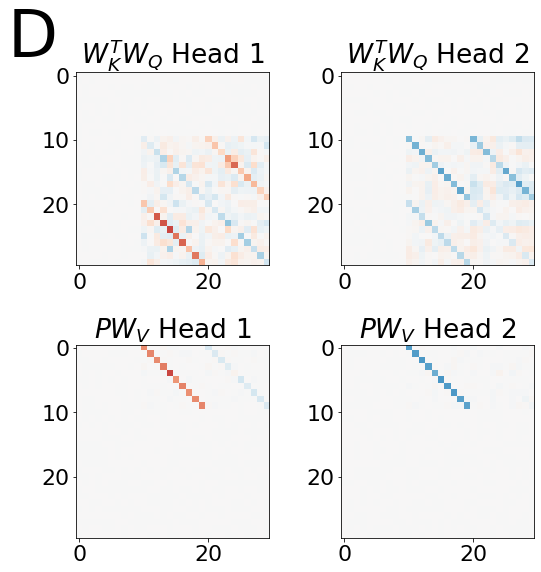

In [31]:
def plot_w(state, key_size, scale):
    params = state.params
    params = state.params
    access_name = 'blocklist_0'

    plt.rcParams.update({'font.size': 22})
    plt.rc('axes', labelsize=20)
    plt.rcParams.update({
        "text.usetex": False,
    })

    fig, axs = plt.subplots(2, 2, figsize=(18, 8))

    colors = plt.colormaps['Dark2']
    colors = iter([colors(i) for i in range(20)])

    q_weights = params['tf_block'][access_name]['self_attn']['q_proj']['kernel']
    k_weights = params['tf_block'][access_name]['self_attn']['k_proj']['kernel']
    v_weights = params['tf_block'][access_name]['self_attn']['v_proj']['kernel']
    p_weights = params['tf_block'][access_name]['self_attn']['o_proj']['kernel']

    W_q1, W_q2 = jnp.split(q_weights, 2, axis=1)
    W_k1, W_k2 = jnp.split(k_weights, 2, axis=1)
    W_v1, W_v2 = jnp.split(v_weights, 2, axis=1)
    P = p_weights

    def fix_mat(KtQ1):
        KtQ1 = jnp.concatenate((KtQ1[:10,:], KtQ1[20:,:]),axis=0)
        KtQ1 = jnp.concatenate((KtQ1[:,:10], KtQ1[:,20:]),axis=1)
        return KtQ1

    KtQ1 = fix_mat((jnp.matmul(W_q1, W_k1.T)))
    PWv1 = fix_mat(jnp.matmul(W_v1, P[0:key_size,:]))
    KtQ2 = fix_mat(jnp.matmul(W_q2,W_k2.T))
    PWv2 = fix_mat(jnp.matmul(W_v2, P[key_size:2*key_size,:]))

    K_min = min([KtQ1.min(), KtQ2.min()])
    K_max = max([KtQ1.max(), KtQ2.max()])
    k = max(abs(K_min), abs(K_max))*scale
    norm_KtQ = TwoSlopeNorm(vmin=-k, vmax=k, vcenter=0)

    PWv_min = min([PWv1.min(), PWv2.min()])
    PWv_max = max([PWv1.max(), PWv2.max()])
    p = max(abs(PWv_min), abs(PWv_max))*scale
    norm_PWv = TwoSlopeNorm(vmin=-p, vmax=p, vcenter=0)

    im1 = axs[0,0].imshow(KtQ1.T, cmap='RdBu', norm=norm_KtQ)
    axs[0,0].set_title("$W^T_K W_Q$ Head $1$")
    im2 = axs[1,0].imshow(PWv1.T, cmap='RdBu', norm=norm_PWv)
    axs[1,0].set_title("$P W_V$ Head $1$")

    axs[0,1].imshow(KtQ2.T, cmap='RdBu', norm=norm_KtQ)
    axs[0,1].set_title("$W^T_K W_Q$ Head $2$")
    axs[1,1].imshow(PWv2.T, cmap='RdBu', norm=norm_PWv)
    axs[1,1].set_title("$P W_V$ Head $2$")

    fig.tight_layout(rect=[0, 0, 0.6, 1])
    
    label_size = 65
    fig.text(0.07, 1.01, 'D', fontsize=label_size, va='top', ha='left')

    if store_results:
        fig.savefig('contracting_weights.pdf', bbox_inches='tight', pad_inches=0.1)
    
    plt.show()
    
plot_w(state_tf_contracting_1,
       key_size=20,
       scale=1.5)

## Fixed-teacher linear dynamical systems:

### Single-layer:

In [32]:
exp_config_fixedw = get_experiment_config(experiment='fixed_w_constr', seeds=[1, 11, 111, 1111, 11111])
exp_config_fixedw.optim.peak_lr = 1e-3
(model_tf_fixedw_1, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr_lay(1)), 
                                                                                        experiment_config=exp_config_fixedw).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_fixedw_1, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(100):
        state_tf_fixedw_1, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_tf_fixedw_1,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_fixedw_1}')
        a = {'params' : state_tf_fixedw_1.params}
        with open(path_model_fixedw_1, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_fixedw_1, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_fixedw_1 = train_state.TrainState.create(apply_fn=model_tf_fixedw_1.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_transformer  layers: 1  heads:  2  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [33]:
exp_config_fixedw.optim.peak_lr = 4e-4
(model_mesa_fixedw, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr['full_mesa']), 
                                                                                        experiment_config=exp_config_fixedw).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_mesa_fixedw, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
        state_mesa_fixedw, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_mesa_fixedw,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_fixedw_mesa}')
        a = {'params' : state_mesa_fixedw.params}
        with open(path_model_fixedw_mesa, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_fixedw_mesa, 'rb') as handle:
        a = pkl.load(handle)
    state_mesa_fixedw = train_state.TrainState.create(apply_fn=model_mesa_fixedw.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_mesa  layers: 1  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [38]:
gd_solver = GDSequenceSolver(eta=0.000883434,
                             lamb=0.0)

if rerun_models:
    gd_solver.opt_eta(minv=0.00001,
                    maxv=0.1,
                    steps=25,
                    data_generator=data_generator,
                    loss_fn=_compute_loss,
                    constr=True)
model_names = ['transformer', 'gd']

seq_evaluator = SequencePredictionEvaluator(data_generator=data_generator,
                                            test_batch_size=256,
                                            seeds=exp_config_fixedw.seeds,
                                            model_list = model_names,
                                            models = [model_tf_fixedw_1, gd_solver],
                                            states = [state_tf_fixedw_1, None],
                                            loss_fn = loss_fn)
if rerun_models:
    seq_loss_dict_one_fixedw = seq_evaluator.run()
    if store_results:
        print(f'Storing performance evaluation dict. in path=\'{path_seqperf_fixedw_single}\'')
        with open(path_seqperf_fixedw_single, 'wb') as handle:
            pkl.dump(seq_loss_dict_one_fixedw, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_seqperf_fixedw_single, 'rb') as handle:
        seq_loss_dict_one_fixedw = pkl.load(handle)

### Multi-layer:

In [39]:
exp_config_fixedw = get_experiment_config(experiment='fixed_w_constr', seeds=[1, 11, 111, 1111, 11111])
exp_config_fixedw.optim.peak_lr = 1e-3
(model_tf_fixedw_2, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr_lay(2)), 
                                                                                        experiment_config=exp_config_fixedw).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_fixedw_2, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(100):
        state_tf_fixedw_2, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_tf_fixedw_2,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_fixedw_2}')
        a = {'params' : state_tf_fixedw_2.params}
        with open(path_model_fixedw_2, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_fixedw_2, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_fixedw_2 = train_state.TrainState.create(apply_fn=model_tf_fixedw_2.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_transformer  layers: 2  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [40]:
exp_config_fixedw = get_experiment_config(experiment='fixed_w_constr', seeds=[1, 11, 111, 1111, 11111])
exp_config_fixedw.optim.peak_lr = 1e-3
(model_tf_fixedw_4, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr_lay(4)), 
                                                                                        experiment_config=exp_config_fixedw).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_fixedw_4, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
        state_tf_fixedw_4, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_tf_fixedw_4,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_fixedw_4}')
        a = {'params' : state_tf_fixedw_4.params}
        with open(path_model_fixedw_4, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_fixedw_4, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_fixedw_4 = train_state.TrainState.create(apply_fn=model_tf_fixedw_4.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_transformer  layers: 4  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [41]:
exp_config_fixedw = get_experiment_config(experiment='fixed_w_constr', seeds=[1, 11, 111, 1111, 11111])
exp_config_fixedw.optim.peak_lr = 1e-3
(model_tf_fixedw_6, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr_lay(6)), 
                                                                                        experiment_config=exp_config_fixedw).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_fixedw_6, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(50):
        state_tf_fixedw_6, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                              state=state_tf_fixedw_6,
                                                                              rng=train_rng,
                                                                              test_rng=test_rng,
                                                                              num_batches_train=100,
                                                                              interpolate=False)
    if store_results:
        print(f'Storing params at {path_model_fixedw_6}')
        a = {'params' : state_tf_fixedw_6.params}
        with open(path_model_fixedw_6, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_fixedw_6, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_fixedw_6 = train_state.TrainState.create(apply_fn=model_tf_fixedw_6.apply, params=a['params'], tx=optimizer)

model:  fully_obs_constructed_transformer  layers: 6  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  False  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  True  clip:  True  clip_val:  4


In [42]:
if rerun_models:
    alphas_fixedw, betas_fixedw = learn_parameters_chebyshev(num_steps=6, 
                                                             train_len=20000, 
                                                             experiment_config=exp_config_fixedw, 
                                                             data_generator=data_generator.data_generator)    # We use the "underlying" data-generator from the constructed-data generator
    if store_results:
        print(f'Storing params at {path_chebyshev_fixedw}')
        with open(path_chebyshev_fixedw, 'wb') as handle:
            pkl.dump({'alphas': alphas_fixedw, 'betas': betas_fixedw}, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_chebyshev_fixedw, 'rb') as handle:
        a = pkl.load(handle)
    alphas_fixedw = a['alphas']
    betas_fixedw = a['betas']

lsq_solver = LeastSquaresSequenceSolver(approximator='chebyshev',
                                        seq_len=50,
                                        alphas=alphas_fixedw,
                                        betas=betas_fixedw)

if rerun_models:
    opt_l = lsq_solver.opt_lamb(minv=0.001, 
                                maxv=0.1, 
                                steps=25, 
                                data_generator=data_generator,
                                loss_fn=_compute_loss,
                                part_obs_constr=False,
                                constr=True)

In [43]:
model_names = ['transformer','transformer','transformer','transformer','mesa-transformer','lsq']
loss_fn = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))
seq_evaluator = SequencePredictionEvaluator(data_generator=data_generator,
                                            test_batch_size=256,
                                            seeds=exp_config_fixedw.seeds,
                                            model_list = model_names,
                                            models = [model_tf_fixedw_1, model_tf_fixedw_2, model_tf_fixedw_4, model_tf_fixedw_6, model_mesa_fixedw, lsq_solver],
                                            states = [state_tf_fixedw_1, state_tf_fixedw_2, state_tf_fixedw_4, state_tf_fixedw_6, state_mesa_fixedw, None],
                                            loss_fn = loss_fn)

if rerun_models:
    seq_loss_dict_multi_fixedw = seq_evaluator.run()
    if store_results:
        print(f'Storing performance evaluation dict. in path=\'{path_seqperf_fixedw_multi}\'')
        with open(path_seqperf_fixedw_multi, 'wb') as handle:
            pkl.dump(seq_loss_dict_multi_fixedw, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_seqperf_fixedw_multi, 'rb') as handle:
        seq_loss_dict_multi_fixedw = pkl.load(handle)

In [45]:
layer_prober = ProbeLayers(experiment_config=exp_config_fixedw,
                           data_generator=data_generator,
                           model_tf=model_tf_fixedw_6,
                           state_tf=state_tf_fixedw_6,
                           probes_list=['curr_probe', 'next_probe', 'inverse_curr_probe'],
                           inv_fn=aux.batched_chebyshev(6, alphas_fixedw, betas_fixedw),
                           probe_lambda=0.001,
                           clean_target_probe=False)
if rerun_models:
    result_dict = layer_prober.run()
    if store_results:
        print(f'Storing probing dict. in path=\'{path_probing_fixedw_multi}\'')
        with open(path_probing_fixedw_multi, 'wb') as handle:
            pkl.dump(result_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_probing_fixedw_multi, 'rb') as handle:
        result_dict = pkl.load(handle)

### Visualize Results:

**Results:**

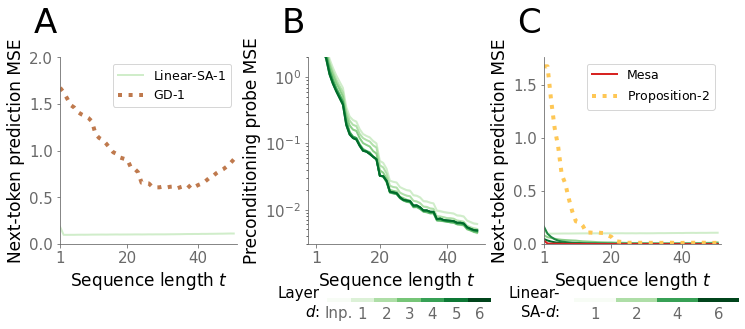

In [51]:
legend_fontsize = 'small'

def subplot_probe(ax,
                  cols: List,
                  mean: List,
                  std: List,
                  name: str,
                  num_graphs: int):
    for i in range(num_graphs):
        c = cols[i]
        linestyle = 'solid'
        ax.plot(jnp.array(mean)[:,i], linewidth=2, color=c, linestyle=linestyle, label=f'$d={i}$')
        ax.fill_between(range(mean.shape[0]), (mean[:,i]-std[:,i]),(mean[:,i]+std[:,i]) ,alpha=0.3, facecolor=c)
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel(name)
    ax.set_yscale('log')
    ax.set_xticks([0,19,39],[1,20,40],fontsize=16)

def subplot_perf_f(ax,
                 seq_loss_dict: Dict[str, any],
                 model_list: List[str],
                 cols: List):
    
    loss_list = seq_loss_dict['losses']
    loss_arr = jnp.array(loss_list)
    mean_losses = tuple([jnp.mean(loss_arr[idx],axis=0) for idx in range(len(model_list))])   # LSA vs GDexact vs Mesa vs LSQ
    std_losses = tuple([jnp.std(loss_arr[idx],axis=0) for idx in range(len(model_list))])
    for idx in range(len(model_list)):
        ax.plot(mean_losses[idx], linewidth=2*(2 if model_list[idx][:3] in ['GD-', 'LSQ', 'Pro'] else 1), linestyle='dotted' if model_list[idx][:3] in ['GD-', 'LSQ', 'Pro'] else 'solid', label=model_list[idx], color=cols[idx])
        ax.fill_between(range(len(mean_losses[0])),
                        (mean_losses[idx] - std_losses[idx]),
                        (mean_losses[idx] - std_losses[idx]),
                        alpha=0.3,
                        facecolor=cols[idx])
        
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel('Next-token prediction MSE')
    ax.set_xlim(0,50)
    ax.set_ylim(0,)
    ax.legend(loc=1, fontsize=legend_fontsize)
    ax.set_xticks([0,19,39],[1,20,40])

def plot_fixedw(result_dict_probe: Dict[str, any],
                seq_loss_dict: Dict[str, any],
                seq_loss_dict_one: Dict[str, any],
                model_list: List):

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })

    # Extract Probe info:
    results_prob = result_dict_probe['results']
    _, next_probes, inv_curr_probes, _, _ = tuple([jnp.array(res) for res in results_prob])
    mean_next_probes = jnp.mean(next_probes, axis=0)[1:,:]
    mean_inv_curr_probes = jnp.mean(inv_curr_probes, axis=0)[1:,:]
    std_inv_curr_probes = jnp.std(inv_curr_probes, axis=0)[1:,:]


    num_graphs = len(mean_next_probes[1])
    colormap_lin = plt.get_cmap('Greens', 100)
    subplot_col_fn = lambda colmap : [colmap(i) for i in [10+(80//num_graphs)*(k+1) for k in range(num_graphs)]]

    c_tf6 = subplot_col_fn(colormap_lin)[-1]
    c_tf1 = subplot_col_fn(colormap_lin)[0]
    c_tf2 = subplot_col_fn(colormap_lin)[2]
    c_tf4 = subplot_col_fn(colormap_lin)[5]
    c_lsq = plt.get_cmap('YlOrBr', 100)(36)
    c_mesa = plt.get_cmap('Reds', 100)(70)

    cols_p2 = [c_tf1,c_tf2,c_tf4,c_tf6,c_mesa,c_lsq]

    fig, axs = plt.subplots(nrows=1,
                            ncols=3,
                            figsize=(10, 4),
                            gridspec_kw={'width_ratios': [1,1,1]},
                            layout='constrained')

    ################################################
    # Probe Targets:
    c_tf1 = subplot_col_fn(colormap_lin)[0]
    c_gd = plt.get_cmap('copper', 100)(60)

    cols_p1 = [c_tf1,c_gd]

    subplot_perf_f(ax=axs[0],
                 seq_loss_dict=seq_loss_dict_one,
                 model_list=['Linear-SA-$1$', 'GD-$1$'],
                 cols=cols_p1)
    axs[0].set_ylim(0,2)
    ################################################
    # Probe Inverse:
    subplot_probe(ax=axs[1],
                  cols=subplot_col_fn(colormap_lin),
                  mean=mean_inv_curr_probes,
                  std=std_inv_curr_probes,
                  name='Preconditioning probe MSE',
                  num_graphs = num_graphs)
    axs[1].set_ylim(0.003,2)
    
    box = axs[1].get_position()
    cbar_height = 0.015  
    space_between = 0.0  
    cbar_offset = 0.15  
    cbar_ax1 = fig.add_axes([box.x0+0.05, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_lin
    bounds = [1,2,3,4,5,6,7,8]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_lin),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["Inp.", "$1$", "$2$", "$3$", "$4$", "$5$", "$6$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 + 0.04, label_y_position+0.005, 'Layer\n$d$:', va='center', ha='right', rotation='horizontal')


    ################################################
    # Performance - Analyses:
    subplot_perf_f(ax=axs[2],
                   seq_loss_dict=seq_loss_dict,
                   model_list=model_list,
                   cols=cols_p2)
    
    #axs[2].set_ylim(0,2)
    box = axs[2].get_position()
    cbar_height = 0.015 
    space_between = 0.0 
    cbar_offset = 0.15 
    cbar_ax1 = fig.add_axes([box.x0+0.12, box.y0 - cbar_offset, box.width, cbar_height])

    cmap = colormap_lin
    bounds = [1,2,3,4,5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cs1 = fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap=colormap_lin),
                 orientation='horizontal',
                 cax=cbar_ax1)

    mid_points = [(bounds[i] + bounds[i + 1]) / 2 for i in range(len(bounds) - 1)]
    cs1.set_ticks(mid_points)
    cs1.set_ticklabels(["$1$", "$2$", "$4$", "$6$"],color='dimgray')

    cbar_ax1.set_frame_on(False)
    cbar_ax1.set_frame_on(False)
    cbar_ax1.xaxis.set_tick_params(size=0)
    label_y_position = box.y0 - cbar_offset - (cbar_height / 2) - space_between / 2
    fig.text(box.x0 + 0.1, label_y_position+0.005, 'Linear-\nSA-$d$:', va='center', ha='right', rotation='horizontal')
    ################################################

    label_size = 34
    axs[0].text(-0.15, 1.27, 'A', transform=axs[0].transAxes, fontsize=label_size, va='top')
    axs[1].text(-0.15, 1.27, 'B', transform=axs[1].transAxes, fontsize=label_size, va='top')
    axs[2].text(-0.15, 1.27, 'C', transform=axs[2].transAxes, fontsize=label_size, va='top')

    if store_results:
        fig.savefig('fixedw_results.pdf', bbox_inches='tight', pad_inches=0.1)

    plt.show()

plot_fixedw(result_dict_probe = result_dict,
            seq_loss_dict_one = seq_loss_dict_one_fixedw['seq_loss_dict'],
            seq_loss_dict = seq_loss_dict_multi_fixedw['seq_loss_dict'],
            model_list = ['','','','','Mesa','Proposition-$2$'])

**Weights:**

(40, 40)
(40, 40)
(40, 40)
(40, 40)


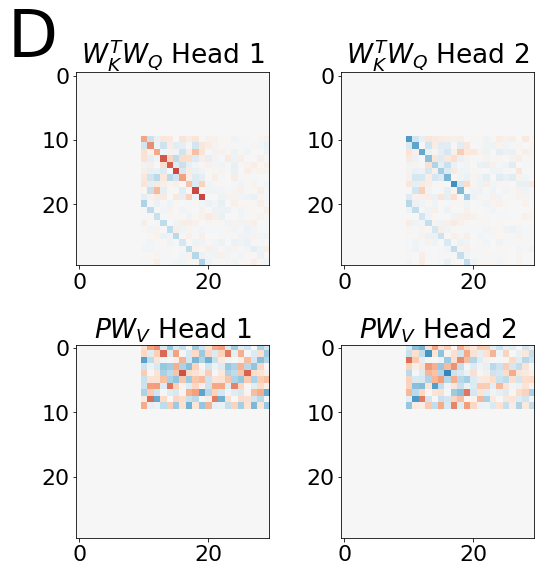

In [52]:
def plot_w(state, key_size, scale):
    params = state.params
    params = state.params
    access_name = 'blocklist_0'

    plt.rcParams.update({'font.size': 22})
    plt.rc('axes', labelsize=20)
    plt.rcParams.update({
        "text.usetex": False,
    })

    fig, axs = plt.subplots(2, 2, figsize=(18, 8))


    colors = plt.colormaps['Dark2']
    colors = iter([colors(i) for i in range(20)])

    q_weights = params['tf_block'][access_name]['self_attn']['q_proj']['kernel']
    k_weights = params['tf_block'][access_name]['self_attn']['k_proj']['kernel']
    v_weights = params['tf_block'][access_name]['self_attn']['v_proj']['kernel']
    p_weights = params['tf_block'][access_name]['self_attn']['o_proj']['kernel']

    W_q1, W_q2 = jnp.split(q_weights, 2, axis=1)
    W_k1, W_k2 = jnp.split(k_weights, 2, axis=1)
    W_v1, W_v2 = jnp.split(v_weights, 2, axis=1)
    P = p_weights

    def fix_mat(KtQ1):
        KtQ1 = jnp.concatenate((KtQ1[:10,:], KtQ1[20:,:]),axis=0)
        KtQ1 = jnp.concatenate((KtQ1[:,:10], KtQ1[:,20:]),axis=1)
        return KtQ1

    KtQ1 = fix_mat((jnp.matmul(W_q1, W_k1.T)))
    PWv1 = fix_mat(jnp.matmul(W_v1, P[0:key_size,:]))
    KtQ2 = fix_mat(jnp.matmul(W_q2,W_k2.T))
    PWv2 = fix_mat(jnp.matmul(W_v2, P[key_size:2*key_size,:]))

    K_min = min([KtQ1.min(), KtQ2.min()])
    K_max = max([KtQ1.max(), KtQ2.max()])
    k = max(abs(K_min), abs(K_max))*scale
    norm_KtQ = TwoSlopeNorm(vmin=-k, vmax=k, vcenter=0)

    # Find min and max values for PWv matrices
    PWv_min = min([PWv1.min(), PWv2.min()])
    PWv_max = max([PWv1.max(), PWv2.max()])
    p = max(abs(PWv_min), abs(PWv_max))*scale
    norm_PWv = TwoSlopeNorm(vmin=-p, vmax=p, vcenter=0)

    im1 = axs[0,0].imshow(KtQ1.T, cmap='RdBu', norm=norm_KtQ)
    axs[0,0].set_title("$W^T_K W_Q$ Head $1$")
    im2 = axs[1,0].imshow(PWv1.T, cmap='RdBu', norm=norm_PWv)
    axs[1,0].set_title("$P W_V$ Head $1$")

    # Plot second pair of matrices in second subplot
    axs[0,1].imshow(KtQ2.T, cmap='RdBu', norm=norm_KtQ)
    axs[0,1].set_title("$W^T_K W_Q$ Head $2$")
    axs[1,1].imshow(PWv2.T, cmap='RdBu', norm=norm_PWv)
    axs[1,1].set_title("$P W_V$ Head $2$")

    fig.tight_layout(rect=[0, 0, 0.6, 1])
    
    label_size = 65
    fig.text(0.07, 1.01, 'D', fontsize=label_size, va='top', ha='left')

    if store_results:
        fig.savefig('fixedw_weights.pdf', bbox_inches='tight', pad_inches=0.1)
    
    plt.show()
plot_w(state_tf_fixedw_1,
       key_size=20,
       scale=1.5)